# Demodulacija MFSK -- v1

### biblioteke

In [1]:
import numpy as np
import fastgoertzel as G
from scipy.io import wavfile
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import exists
# import librosa
import scipy.fft as fft
import scipy
from scipy.signal import remez,freqz,firwin
import decimal
from scipy.signal import find_peaks
# from scipy.signal import findfre2
import binascii
from scipy import signal
%matplotlib widget
#%matplotlib notebook

/home/zarko/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### selektor i ucitavanje fajla

In [5]:
def biraj_folder() -> FileChooser:
    # biranje foldera
    fc = FileChooser()
    fc.show_only_dirs = True

    # brza pretraga da nadje default folder, sto da ne
    for dirname,_,_ in os.walk(fc.default_path):
        if Path(dirname).name == "wav":
            fc.default_path = dirname
            fc._select_default = True  ## da ne moramo da selektujemo svaki put
            fc.reset()
            break
    # ovo valjda odradi posao
    display(fc)
    return fc

def ucitaj_fajl(fc:FileChooser):
    global samplerate, sig
    selected = os.fsencode(fc.selected)
    
    if os.path.isfile(selected):
        try:
            # sig, samplerate = librosa.load(fc.selected + filename) 
            samplerate, sig = wavfile.read(fc.selected) 
            return(samplerate, sig)
        
        except:
            print("greska sa citanjem fajla:" + fc.selected)
    

def biraj_fajl():
    # biranje fajla
    fc = FileChooser()
    fc.register_callback(ucitaj_fajl)   
    display(fc)
    # return fc
biraj_fajl()

FileChooser(path='/home/zarko/PFE/LK_S_2024/skriveni-kanali', filename='', title='', show_hidden=False, select…

### sanity check spektogram fajla

/home/zarko/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


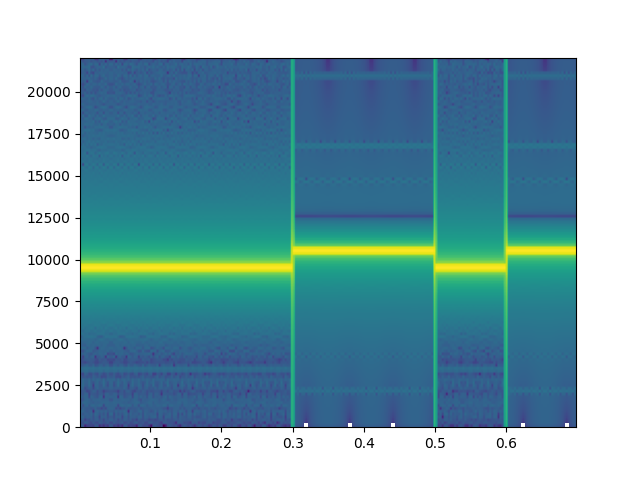

In [6]:
plt.clf()
plt.specgram(sig,Fs = samplerate)
plt.show()

### bandpass filter testing -- incomplete

In [ ]:
samplerate=44100

t = np.linspace(0,len(sig/samplerate),len(sig))
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)

ax1.plot(t, sig)

f0 = 2000
f1 = 5000
ax1.set_title(f'{f0} Hz and {f1} Hz sinusoids')
ax1.axis([0, 1, -2, 2])

sos = scipy.signal.butter(3,[f0 - 200,f0 + 200],fs=samplerate,btype="band",output="sos")
# w,h = scipy.signal.freqs(b,a)
filtered_signal =scipy.signal.sosfiltfilt(sos,sig)
ax2.plot(t, filtered_signal)
ax2.set_title('After {f0} Hz bandpass')

ax2.axis([0, 1, -2, 2])

ax2.set_xlabel('Time [seconds]')

sos2 = scipy.signal.butter(3,[f1-200,f1+200],fs=samplerate,btype="band",output="sos")
filtered_signal2 =scipy.signal.sosfiltfilt(sos2,sig)
ax3.plot(t,filtered_signal2)
ax3.axis([0, 1, -2, 2])


plt.tight_layout()

plt.show()

In [ ]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, sig)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 40000.0
    lowcut = 900.0
    highcut = 1100.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 1
    nsamples = T * fs
    t = np.linspace(0, T, int(nsamples), endpoint=False)
    a = 0.02
    f0 = 1000.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show() 

### goertzel demod v1 -- incomplete, odd behaviour

In [ ]:
start_time = 0
end_time = 1
sample_rate = 44100
time = np.arange(start_time, end_time, 1/sample_rate)
theta = 0
frequency = 2000
amplitude = 1
sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)

In [27]:
sig = sig
dt = 0.1
f0 = 2000
f1 = 5000
a = []
b = []
small_segment = int(samplerate * dt  * 0.01)
small_segment = 50
for i in np.arange(0,len(sig)/samplerate,dt):
    amp1,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate - small_segment)]/1,f0)
    a.append(amp1)

In [28]:
for i in np.arange(0,len(sig)/samplerate,dt):
    amp2,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate - small_segment) ]/1,f1)
    b.append(amp2)

In [ ]:
plt.clf()
plt.plot(b)
plt.plot(a)
plt.show()

## simple demodulation using FFT

In [8]:
class BitAppender:
    def __init__(self):
        self.buffer = bytearray()
        self.current_byte = 0
        self.bit_count = 0

    def append_bit(self, bit):
        if bit not in (0, 1):
            raise ValueError("Bit must be 0 or 1")

        # Add the bit to the current byte
        self.current_byte = (self.current_byte << 1) | bit
        self.bit_count += 1

        # If we have accumulated 8 bits, store the byte and reset
        if self.bit_count == 8:
            self.buffer.append(self.current_byte)
            self.current_byte = 0
            self.bit_count = 0

    def get_bytes(self):
        # If there are leftover bits, pad with zeros and add the final byte
        if self.bit_count > 0:
            self.current_byte <<= (8 - self.bit_count)
            self.buffer.append(self.current_byte)
        return bytes(self.buffer)

# Example usage:
# bit_appender = BitAppender()
# bits = [1, 0, 1, 1, 0, 0, 1, 0,  # 0b10110010 (178 in decimal)
#         1, 1, 1, 1, 0, 0, 1, 1]  # 0b11110011 (243 in decimal)

# for bit in bits:
#     bit_appender.append_bit(bit)

# result = bit_appender.get_bytes()
# print(result)  # Output: b'\xb2\xf3'


In [9]:
dt = 0.1
# f0 = 2000
# f1 = 5000
f0=9500
f1=10500
bit_appender = BitAppender()


small_segment = int(samplerate * dt  * 0.01)
small_segment = 50 # mali delic tako da ne uhvatimo prelaze frekvencija i olaksamo potrebe sinhronizacije
small_segment = 100

N = len(sig)

T = 1.0 / samplerate
x = np.linspace(0.0, N*T, N)
y = sig

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
peak_tresh = 10000000 ### eksperimentalno utvrdjen tresh za peak-finder, curr unused

binlist = bytearray

bl = []
for i in np.arange(0,len(sig)/samplerate,dt):
    y1 = sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment]/1
    y1fft = scipy.fft.rfft(y1)
    n = int(dt * samplerate)- 2 * small_segment

    freqs = fft.rfftfreq(n,1./samplerate)
    # peaks,props = find_peaks(y1fft,height = peak_tresh)
 
    if f0-300 < freqs[y1fft[15:].argmax()] < f0 + 300: bit_appender.append_bit(0);bl.append(0)
    if f1-300 < freqs[y1fft[15:].argmax()] < f1 +300: bit_appender.append_bit(1);bl.append(1)
       
result = bit_appender.get_bytes()
print(result)  # Output: b'\xb2\xf3'
print(bl)

b'\x1a'
[0, 0, 0, 1, 1, 0, 1]


In [11]:
print(bit_appender.get_bytes())

b'\x1a4'


### bit comparison, semi-manual

In [13]:
st = "sifra sifra"
print(' '.join(format(ord(x), 'b').zfill(8) for x in st))
print(' '.join(format(ord(x), 'b').zfill(8) for x in bit_appender.get_bytes().decode("utf-8")))
# ' '.join(format(ord(i),'b').zfill(8) for i in st)

01110011 01101001 01100110 01110010 01100001 00100000 01110011 01101001 01100110 01110010 01100001
00011010 00110100


### Digital signal plots

In [14]:
def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] >> shift) & 0x1


In [63]:
import random
bit_appender = BitAppender()
bit_appender.append_bit(1)
for i in range(6):
    bit_appender.append_bit(int(random.random()))

bit_appender.append_bit(1)
print(bit_appender.get_bytes())

b'\x81'


[1, 0, 0, 0, 0, 0, 0, 1]
0   1
1   0
2   0
3   0
4   0
5   0
6   0
7   1


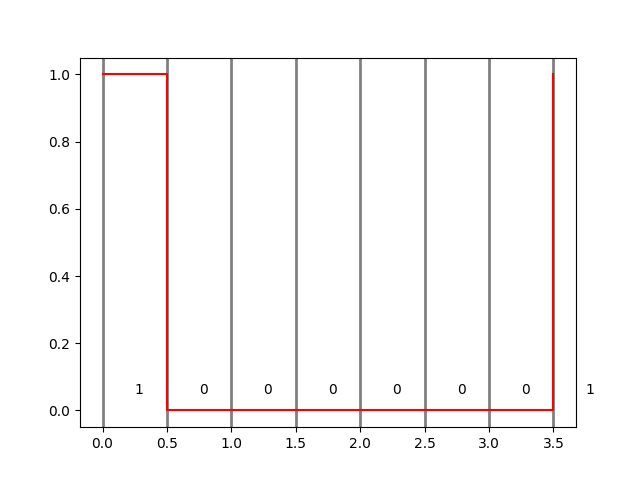

In [65]:
bits = (' '.join(format(ord(x), 'b').zfill(8) for x in st))

niz = [access_bit(bit_appender.get_bytes(),i) for i in range(len(bit_appender.get_bytes())*8)]

niz = niz[:8] # uzimamo prvih pet da plot ne bude previse zgusnut

print(niz)
t = 0.5 * np.arange(len(niz))

plt.clf()
for i in t:
    plt.axvline(i,linewidth=2,color ='.5')
        
plt.step(t, niz,'r',where='post')

for tbit, bit in enumerate(niz):
    print(tbit, " ", bit)
    plt.text(tbit * 0.5 + 0.25, 0.05, str(niz[tbit])) ## ovo i ne radi bes posao nesto, nisam siguran skroz sto, vrv je ispod plota

plt.show()

plt.plot(freqs, np.abs(y1fft), '-', freqs[peaks])

In [ ]:
print(freqs[peaks])

### barker i sinhronizator

In [30]:
# odaberi fajl koji sadrzi samo barkera
biraj_fajl()

FileChooser(path='/home/zarko/PFE/LK_S_2024/skriveni-kanali', filename='', title='', show_hidden=False, select…

In [33]:
barker = sig.copy()

In [34]:
biraj_fajl()

FileChooser(path='/home/zarko/PFE/LK_S_2024/skriveni-kanali', filename='', title='', show_hidden=False, select…

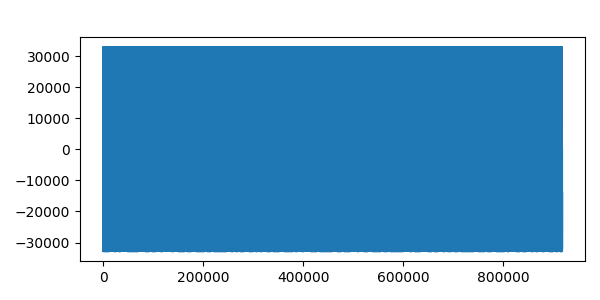

In [44]:
plt.clf()
plt.plot(sig)
plt.show()

/home/zarko/.local/lib/python3.9/site-packages/scipy/signal/_signaltools.py:1426: RuntimeWarning: invalid value encountered in cast
  return out.astype(result_type)


Time lag: -20.764126984126985 seconds
Start index: -884829
longer signal length: 917280
shorter seq length: 30870


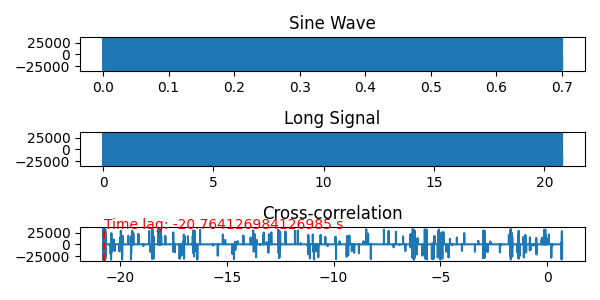

In [51]:
from scipy.signal import correlate


long_signal = sig.copy()
sine_wave = barker.copy()

# Generate a one second sine wave
sampling_rate = 44100  # samples per second
t = np.linspace(0, len(sine_wave)/sampling_rate, len(sine_wave), endpoint=False)
# sine_wave = np.sin(2 * np.pi * 5 * t)  # 5 Hz sine wave

# Generate a longer signal with silence, sine wave, and more silence
silence1 = np.zeros(sampling_rate * 3)  # 2 seconds of silence
# silence2 = np.zeros(sampling_rate * 3)  # 3 seconds of silence
# long_signal = np.concatenate((silence1, sine_wave, silence2))
# long_signal = np.concatenate((silence1, sig))

# Calculate cross-correlation
correlation = correlate(long_signal,sine_wave , mode='full')
lags = np.arange(-len(long_signal) + 1, len(sine_wave))

# Find the index of the maximum correlation
time_lag = lags[np.argmax(correlation)]
start_index = time_lag + len(sine_wave) - 1  # Adjust index due to padding

print(f'Time lag: {time_lag / sampling_rate} seconds')
print(f'Start index: {start_index}')
print(f'longer signal length: {len(long_signal)}')
print(f'shorter seq length: {len(sine_wave)}')

# Plot for visualization
plt.figure(figsize=(6, 3))

plt.subplot(3, 1, 1)
plt.plot(t, sine_wave)
plt.title('Sine Wave')

plt.subplot(3, 1, 2)
plt.plot(np.arange(len(long_signal))     / sampling_rate, long_signal)
plt.title('Long Signal')

plt.subplot(3, 1, 3)
plt.plot(lags / sampling_rate, correlation)
plt.title('Cross-correlation')
plt.axvline(time_lag / sampling_rate, color='r', linestyle='--')
plt.text(time_lag / sampling_rate, max(correlation), f'Time lag: {time_lag / sampling_rate} s', color='r')

plt.tight_layout()
plt.show()


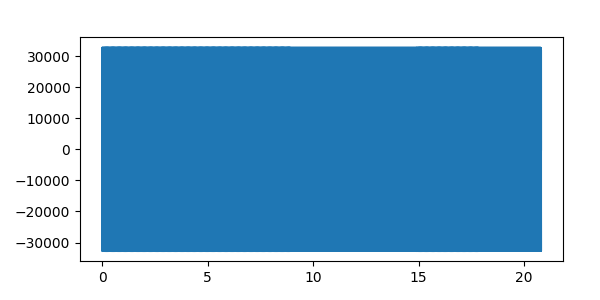

In [48]:
plt.clf()
# plt.plot(signal_orig[len(signal_orig)-458641-2000:])
plt.plot(t, sine_wave)
plt.show()

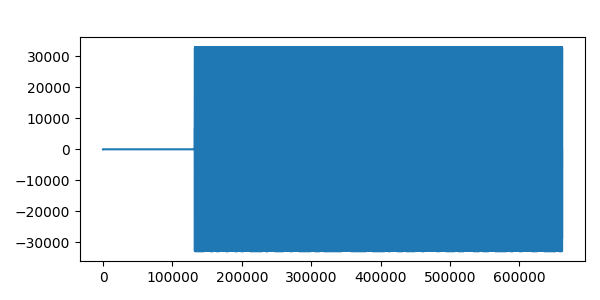

In [70]:
plt.clf()
# plt.plot(signal_orig[len(signal_orig)-458641-2000:])
plt.plot(signal_orig)
plt.show()

In [79]:
sig = sig.astype(np.float32)
sig2 = sig[10000:]
corr = signal.correlate(sig,signal_orig, mode='same',method='direct') 
plt.clf()
plt.plot(corr)
plt.show()

In [46]:
sig_loc = corr.argmax()

In [48]:
print(sig_loc)

149940


In [57]:
def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    print('y2 is ' + str(delay) + ' behind y1')

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()

# Sine sample with some noise and copy to y1 and y2 with a 1-second lag
sr = 44100
y = np.linspace(0, 2*np.pi, sr)
y = np.tile(np.sin(y), 5)
y += np.random.normal(0, 5, y.shape)
y1 = y[sr:4*sr]
y2 = y[:3*sr]
y2 = signal_orig
y1 = sig

# lag_finder(y1, y2, sr)


# rng = default_rng()
# x = rng.standard_normal(1000)
# y = np.concatenate([rng.standard_normal(100), x])
y = signal_orig
x = sig
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]

In [58]:
print(lag)

-132300


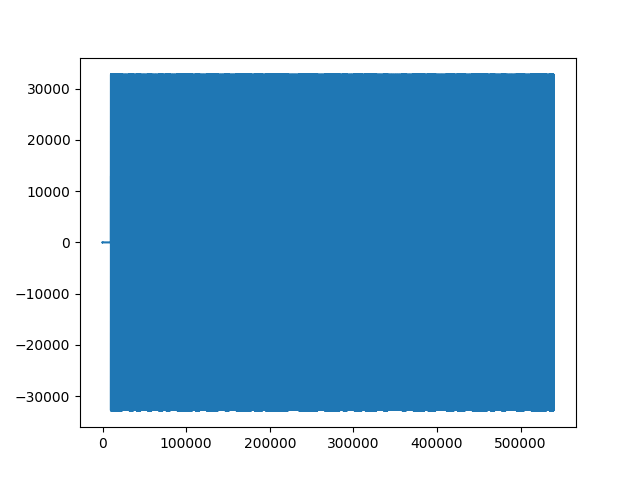

In [59]:
plt.clf()
plt.plot(signal_orig[132300-10000:])
plt.show()